<a href="https://colab.research.google.com/github/RicardoR002/NLP-CAI2300C/blob/main/Book_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Book Recommendation System

Ricardo Ruano
CAI2300C



#Explore Dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Loading the dataset
url = "https://github.com/RicardoR002/NLP-CAI2300C/raw/refs/heads/main/customer_reviews_books.csv"
df = pd.read_csv(url, encoding='ISO-8859-1')

# Displaying the first few rows of the dataset
df.head()
# Initial exploration to understand the structure of the dataset and identify key columns that will be useful for building the recommender system.

,Sno,book name,review title,reviewer,reviewer rating,review description,is_verified,date,timestamp,ASIN
0,0,The Woman in Me,Unbelievably impressive. Her torn life on paper.,Murderess Marbie,4,I'm only a third way in. Shipped lightening fa...,True,26-10-2023,"Reviewed in the United States October 26, 2023",1668009048
1,1,The Woman in Me,What a heartbreaking story,L J,5,"""There have been so many times when I was scar...",True,06-11-2023,"Reviewed in the United States November 6, 2023",1668009048
2,2,The Woman in Me,Britney you are so invincible! You are an insp...,Jamie,5,The media could not be loaded. I personally ha...,True,01-11-2023,"Reviewed in the United States November 1, 2023",1668009048
3,3,The Woman in Me,"Fast Read, Sad Story",KMG,5,I have been a fan of Britney's music since the...,True,25-10-2023,"Reviewed in the United States October 25, 2023",1668009048
4,4,The Woman in Me,"Buy it, itâs worth the read!",Stephanie Brown,5,"Whether or not youâre a fan, itâs a great ...",True,01-11-2023,"Reviewed in the United States November 1, 2023",1668009048


In [2]:
# check for duplicates in book name title keep first(Added this step after getting recommended the same book from different reviews.)
df = df.drop_duplicates(subset='book name', keep='first')

#Preprocess the Text Data

In [3]:
# Handling missing values and converting labels to binary format
df.dropna(subset=['review description'], inplace=True)
df['reviewer rating'] = df['reviewer rating'].map({1: 0, 2: 0, 4: 1, 5: 1})

In [4]:
# Import necessary libraries for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data files (only need to run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
from operator import le
# Define a text preprocessing function
def preprocess_text(text):
  # Convert to string if it's not already
  if not isinstance(text, str):
    text = str(text)

# 1. Lowercase the text
  text = text.lower()

  # 2. Tokenization
  tokens = word_tokenize(text)

  # 3. Remove stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

   # 4. Lemmatize the tokens
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  return tokens

# Ensure all values in 'review description' are strings
df['processed_text'] = df['review description'].astype(str)

# Apply the preprocessing function to the 'review description' column
df['processed_text'] = df['processed_text'].apply(preprocess_text)

# Display the first 5 rows of the 'processed_text' column after preprocessing
df['processed_text'].head()

,processed_text
0,"[third, way, shipped, lightening, print, quali..."
10,"[admit, rarely, watched, friend, episode, firs..."
20,[great]
30,"[one, sunday, visiting, blog, get, often, stum..."
40,"[excited, new, book, come, huge, fan, series, ..."


#Create Word Embeddings

In [6]:
# Create a Word2Vec model
model = Word2Vec(sentences=df['processed_text'], vector_size=100, window=5, min_count=1, workers=4)

# Display the vocabulary size
print(f"Vocabulary size: {len(model.wv.index_to_key)}")

Vocabulary size: 5674


In [7]:
# Extract 10 words from the model's vocabulary
words = model.wv.index_to_key[:10]

# Create a DataFrame to display words and their embeddings
word_embeddings = [model.wv[word] for word in words]
embedding_df = pd.DataFrame(word_embeddings, index=words)

# Display the DataFrame with 10 words and their corresponding embeddings
print(embedding_df)

             0         1         2         3         4         5         6   \
book  -0.024766  0.029579  0.023037  0.008558 -0.002468 -0.068038  0.020828   
one   -0.028633  0.028441  0.020129  0.004745  0.013615 -0.056616  0.012424   
life  -0.016435  0.023414  0.005893 -0.001972  0.013738 -0.035620  0.005905   
read  -0.023240  0.027504  0.011557 -0.002264  0.009173 -0.041311  0.011868   
time  -0.024950  0.023640  0.005932 -0.003228  0.009207 -0.039626  0.011445   
like  -0.024619  0.021355  0.010715 -0.010270 -0.004794 -0.040621  0.013892   
story -0.009097  0.017865  0.012094  0.000215  0.005667 -0.044571  0.016678   
make  -0.007805  0.016198  0.021537  0.007543  0.000572 -0.041153  0.012841   
love  -0.024827  0.028530  0.016368  0.008815  0.011083 -0.036124  0.018820   
would -0.020303  0.012947  0.003777  0.007937  0.003211 -0.046679  0.004618   

             7         8         9   ...        90        91        92  \
book   0.094208 -0.023596 -0.026929  ...  0.044344  0.00

In [8]:
# Function to generate an embedding for each Book Review
def get_book_embedding(tokenized_text, model, embedding_size=100):
    # Get word embeddings for each word in the tokenized text
    valid_embeddings = [model.wv[word] for word in tokenized_text if word in model.wv]

    # If no valid embeddings, return a zero vector of the same size as the word vectors
    if len(valid_embeddings) == 0:
        return np.zeros(embedding_size)


    # Otherwise, return the mean of the valid embeddings
    return np.mean(valid_embeddings, axis=0)

# Apply the function to generate embeddings for each Review
# Make sure to define the embedding size to match the model's vector size(100)
embedding_size = model.vector_size
df['book_embedding'] = df['processed_text'].apply(lambda x: get_book_embedding(x, model, embedding_size=100))

#Validate the embeddings

In [9]:
# Check for invalid embeddings (e.g., NaNs or wrong shapes)
invalid_embeddings = df['book_embedding'].apply(lambda x: x.shape[0] != embedding_size or np.any(np.isnan(x)))

# Print the number of invalid embeddings
print(f"Number of invalid embeddings: {invalid_embeddings.sum()}")

# Filter out invalid embeddings, if any
df = df[~invalid_embeddings]

Number of invalid embeddings: 0


#Visualizing Word Embeddings Using PCA

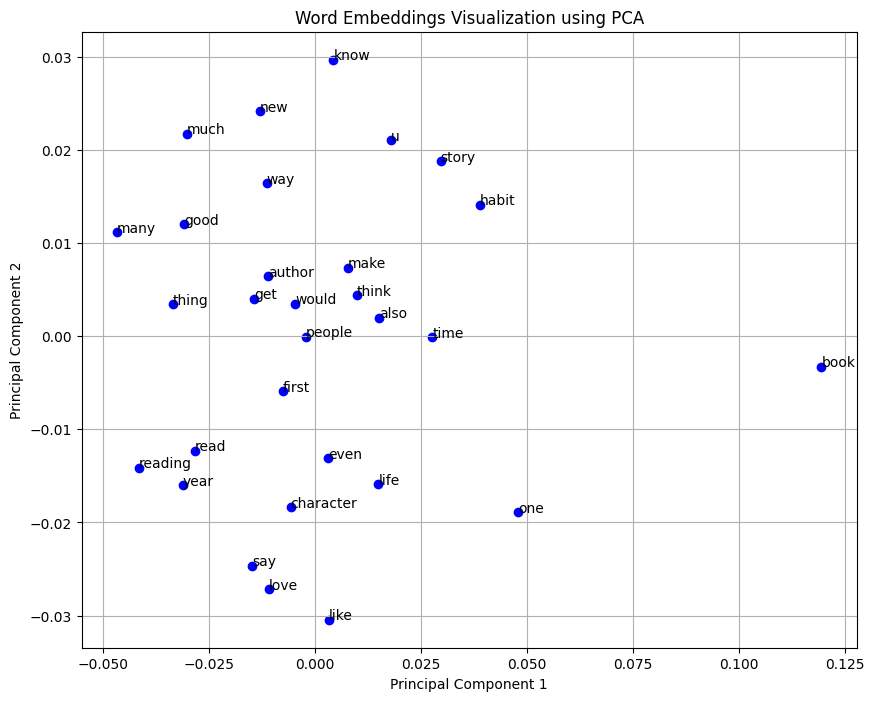

In [10]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Select 30 random words from the vocabulary
words = list(model.wv.index_to_key)[:30]

# Get the word embeddings for these words
word_vectors = [model.wv[word] for word in words]

# Use PCA to reduce the word vectors to 2 dimensions
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], c='blue')

# Annotate each point with the word
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

# Display the plot
plt.title("Word Embeddings Visualization using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

#Calculate Similarity

In [11]:
# Calculate cosine similarity between book embeddings
embeddings_matrix = np.vstack(df['book_embedding'].values)
cosine_sim = cosine_similarity(embeddings_matrix)

# Create a DataFrame for the cosine similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['book name'], columns=df['book name'])

# Display the first 30 books and their similarities
cosine_sim_df_subset = cosine_sim_df.iloc[:30, :30]
cosine_sim_df_subset.head()

book name,The Woman in Me,"Friends, Lovers, and the Big Terrible Thing: A Memoir",How to Catch a Turkey,"Fourth Wing (The Empyrean, 1)",No Brainer (Diary of a Wimpy Kid Book 18),Killers of the Flower Moon: The Osage Murders and the Birth of the FBI,All the Light We Cannot See: A Novel,The Ballad of Songbirds and Snakes (A Hunger Games Novel) (The Hunger Games),Night (Night),Atomic Habits: An Easy & Proven Way to Build Good Habits & Break Bad Ones,...,A Little Life,"World of Eric Carle, Around the Farm 30-Button Animal Sound Book - Great for First Words - PI Kids","Goodnight, Goodnight Construction Site (Board Book for Toddlers, Children's Board Book)",The Leaf Thief: (The Perfect Fall Book for Children and Toddlers),"Brown Bear, Brown Bear, What Do You See?",Balloons over Broadway: The True Story of the Puppeteer of Macy's Parade (Bank Street College of Education Flora Stieglitz Straus Award (Awards)),The Four Agreements: A Practical Guide to Personal Freedom (A Toltec Wisdom Book),The Housemaid,How to Know a Person: The Art of Seeing Others Deeply and Being Deeply Seen,The Very Hungry Caterpillar
book name,,,,,,,,,,,,,,,,,,,,,
The Woman in Me,1.000000,0.995597,0.899380,0.996107,0.996271,0.994436,0.997091,0.997381,0.992321,0.996576,...,0.997508,0.991655,0.973000,0.987424,0.992735,0.982413,0.997284,0.995156,0.996453,0.993254
"Friends, Lovers, and the Big Terrible Thing: A Memoir",0.995597,1.000000,0.901770,0.995897,0.995035,0.994218,0.995796,0.996628,0.991138,0.995602,...,0.996194,0.992203,0.967627,0.987788,0.991031,0.979767,0.997097,0.994472,0.994140,0.991963
How to Catch a Turkey,0.899380,0.901770,1.000000,0.899417,0.901646,0.896822,0.900344,0.902686,0.903415,0.907073,...,0.898618,0.896539,0.906255,0.907375,0.886488,0.897766,0.902774,0.898563,0.902638,0.898568
"Fourth Wing (The Empyrean, 1)",0.996107,0.995897,0.899417,1.000000,0.996259,0.993459,0.996971,0.996788,0.991815,0.996339,...,0.996745,0.992226,0.969621,0.989212,0.991636,0.983015,0.996747,0.994747,0.995575,0.994018
No Brainer (Diary of a Wimpy Kid Book 18),0.996271,0.995035,0.901646,0.996259,1.000000,0.993497,0.996309,0.997676,0.992695,0.996065,...,0.996552,0.993364,0.973883,0.988582,0.994583,0.983319,0.996126,0.993599,0.996637,0.994564


In [12]:
# Create a mapping from book name to index
book_indices = pd.Series(df.index, index=df['book name']).drop_duplicates()

# Function to recommend books based on cosine similarity
def recommend_books(book_name, cosine_sim=cosine_sim, df=df, book_indices=book_indices):
    # Get the index of the book that matches the name
    # Handle the case where the book name is not found in the index
    try:
        idx = book_indices[book_name]
    except KeyError:
        print(f"Book '{book_name}' not found in the dataset.")
        return []  # Return an empty list if the book is not found

    # Ensure idx is within bounds of cosine_sim
    idx = min(idx, cosine_sim.shape[0] - 1)

    # Get the pairwise similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar books
    return df['book name'].iloc[book_indices]

# Example: Reccommend books similar to 'The Christmas Fix'
recommendations = recommend_books('The Christmas Fix')
print(recommendations)

570            The Covenant of Water (Oprah's Book Club)
90     Atomic Habits: An Easy & Proven Way to Build G...
530                                            Elon Musk
720           Harry Potter Paperback Box Set (Books 1-7)
70     The Ballad of Songbirds and Snakes (A Hunger G...
690            Demon Copperhead: A Pulitzer Prize Winner
400    A Court of Thorns and Roses Paperback Box Set ...
630                                               Verity
650                     The Creative Act: A Way of Being
40             No Brainer (Diary of a Wimpy Kid Book 18)
Name: book name, dtype: object


#Recommender Function

In [13]:
# Function to recommend books based on cosine similarity
def recommend_books_with_score(book_name, cosine_sim=cosine_sim, df=df, book_indices=book_indices):
    # Get the index of the book that matches the name
    # Handle the case where the book name is not found in the index
    try:
        idx = book_indices[book_name]
    except KeyError:
        print(f"Book '{book_name}' not found in the dataset.")
        return []  # Return an empty list if the book is not found

    # Ensure idx is within bounds of cosine_sim
    idx = min(idx, cosine_sim.shape[0] - 1)

    # Get the pairwise similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices and similarity scores of the 10 most similar books
    sim_scores = sim_scores[1:11] # Skip the first item since it's the movie itself

    # Get the book indices and similarity scores separately
    book_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]

    # Create a DataFrame with book titles and their similarity scores
    recommendations_df = pd.DataFrame({
        'Book Title': df['book name'].iloc[book_indices],
        'Similarity Score': similarity_scores
    })

    return recommendations_df

# Example: Recommend books similar to 'The Christmas Fix' and print titles with scores
recommendations_with_scores = recommend_books_with_score('The Christmas Fix')
print(recommendations_with_scores)

                                            Book Title  Similarity Score
570          The Covenant of Water (Oprah's Book Club)          0.981326
90   Atomic Habits: An Easy & Proven Way to Build G...          0.979914
530                                          Elon Musk          0.979864
720         Harry Potter Paperback Box Set (Books 1-7)          0.979837
70   The Ballad of Songbirds and Snakes (A Hunger G...          0.979727
690          Demon Copperhead: A Pulitzer Prize Winner          0.979596
400  A Court of Thorns and Roses Paperback Box Set ...          0.979516
630                                             Verity          0.979502
650                   The Creative Act: A Way of Being          0.979435
40           No Brainer (Diary of a Wimpy Kid Book 18)          0.979207


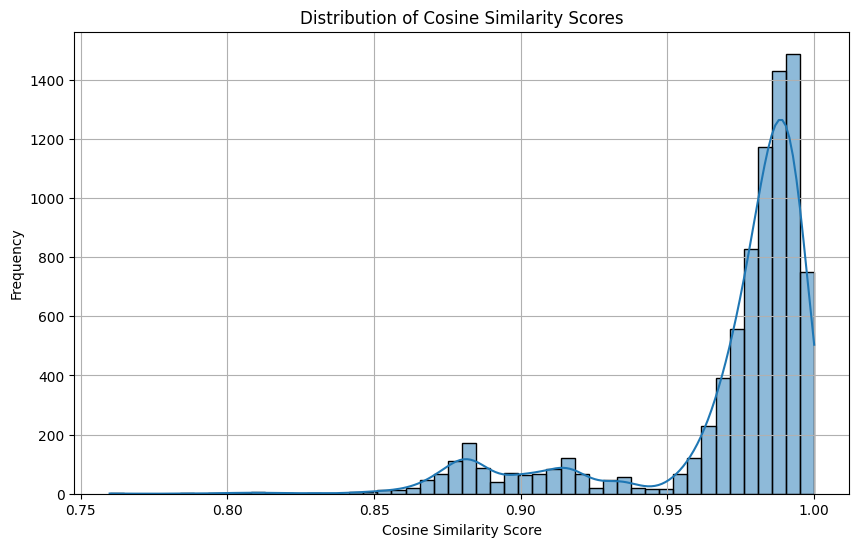

Review Length Statistics:
count      91.000000
mean      243.318681
std       368.899621
min         1.000000
25%        22.500000
50%        90.000000
75%       270.000000
max      1583.000000
Name: review_length, dtype: float64


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the distribution of cosine similarity scores for all books
all_sim_scores = cosine_sim.flatten()

# Plot the distribution of similarity scores
plt.figure(figsize=(10, 6))
sns.histplot(all_sim_scores, bins=50, kde=True)
plt.title("Distribution of Cosine Similarity Scores")
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Check the length of the book reviews
df['review_length'] = df['processed_text'].apply(lambda x: len(x))
print("Review Length Statistics:")
print(df['review_length'].describe())